# Liver Cirhosis Classification

## Data Preprocessing

In [1]:
import copy
import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,roc_curve,auc,confusion_matrix,cohen_kappa_score
from sklearn.model_selection import GridSearchCV,train_test_split
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import warnings 
import time
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')
random.seed(2023)

In [2]:
#Load Dataset
cir_df = pd.read_csv("cirrhosis.csv")

In [3]:
# check the top 5 rows of the data
cir_df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [4]:
# check the last 5 rows of the data
cir_df.tail()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0
417,418,976,C,NaN,19358,F,NaN,NaN,NaN,N,0.7,NaN,3.29,NaN,NaN,NaN,NaN,350.0,10.6,4.0


In [5]:
# check the shape of the data
cir_df.shape

(418, 20)

In [6]:
# check the datatype of the columns
cir_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

### Missing Value

In [7]:
#Check missing values
cir_df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

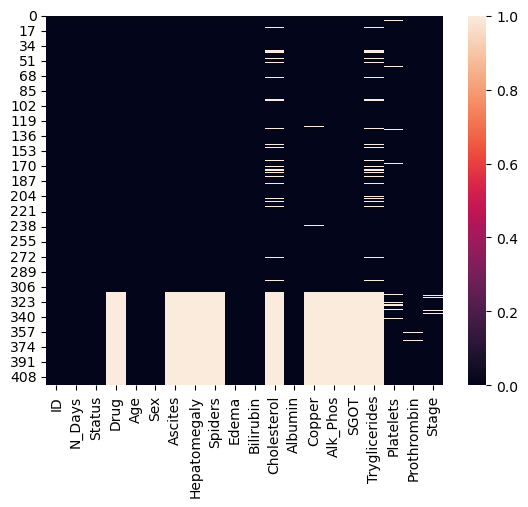

In [8]:
sns.heatmap(cir_df.isnull())
plt.show()

From the heat map above, we can tell there are around 100 patients missing nearly 50% features, and some of those features are bianry. Arbitrarily imputing those values with mean/mode could lead to huge misleading since this is a small dataset and those patients compose nearly 25% of the dataset. So we decide to remove those patients and impute the rest of missing values with means.

Furthermore, certain variables have been transformed in order to enhance comprehensibility and proceed more convenient fitting later.

In [9]:
# filling the missing values in the numeric columns with the median of the respective column
num_cols = cir_df.select_dtypes(include = (['int64', 'float64'])).columns
for col in num_cols:
    cir_df[col].fillna(cir_df[col].median(), inplace=True) 
num_cols.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [10]:
# filling the missing values in the categorical columns with the mode of the respective column
cat_cols = cir_df.select_dtypes(include=('object')).columns
for col in cat_cols:
    cir_df[col].fillna(cir_df[col].mode().values[0], inplace=True) 
cat_cols.isna().sum()

0

In [11]:
# check the duplicated rows in the data
cir_df.duplicated().sum()

0

In [12]:
# drop the 'ID' column as it is unnecessary for the further analysis
cir_df = cir_df.drop(columns = ["ID"])

In [13]:
# check the top 5 rows again
cir_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [14]:
# check the datatype of the columns again
cir_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           418 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        418 non-null    object 
 6   Hepatomegaly   418 non-null    object 
 7   Spiders        418 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    418 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         418 non-null    float64
 13  Alk_Phos       418 non-null    float64
 14  SGOT           418 non-null    float64
 15  Tryglicerides  418 non-null    float64
 16  Platelets      418 non-null    float64
 17  Prothrombin    418 non-null    float64
 18  Stage     

## EDA

In [15]:
cir_df.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,418.0,350.272727,193.123893,120.00,273.0000,309.50,347.75,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,418.0,91.279904,74.485481,4.00,51.2500,73.00,100.75,588.00
Alk_Phos,418.0,1799.144976,1875.121982,289.00,1016.2500,1259.00,1707.75,13862.40
SGOT,418.0,120.564067,49.085094,26.35,91.0000,114.70,135.75,457.25
Tryglicerides,418.0,119.267943,54.050691,33.00,95.0000,108.00,127.75,598.00
Platelets,418.0,256.866029,97.024861,62.00,190.0000,251.00,315.50,721.00


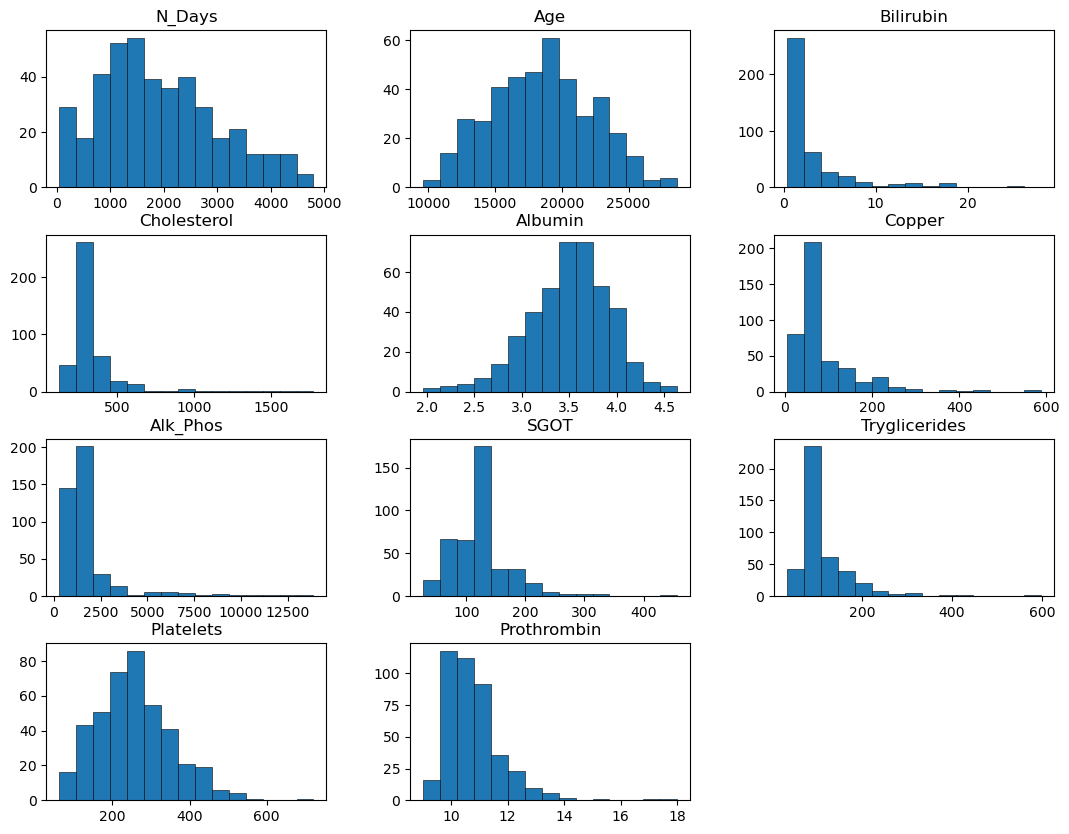

In [16]:
continous_df = cir_df.loc[:, ~cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
histogram = continous_df.hist(figsize=(13, 10), bins = 15 ,grid = False, edgecolor='black', linewidth = 0.4)

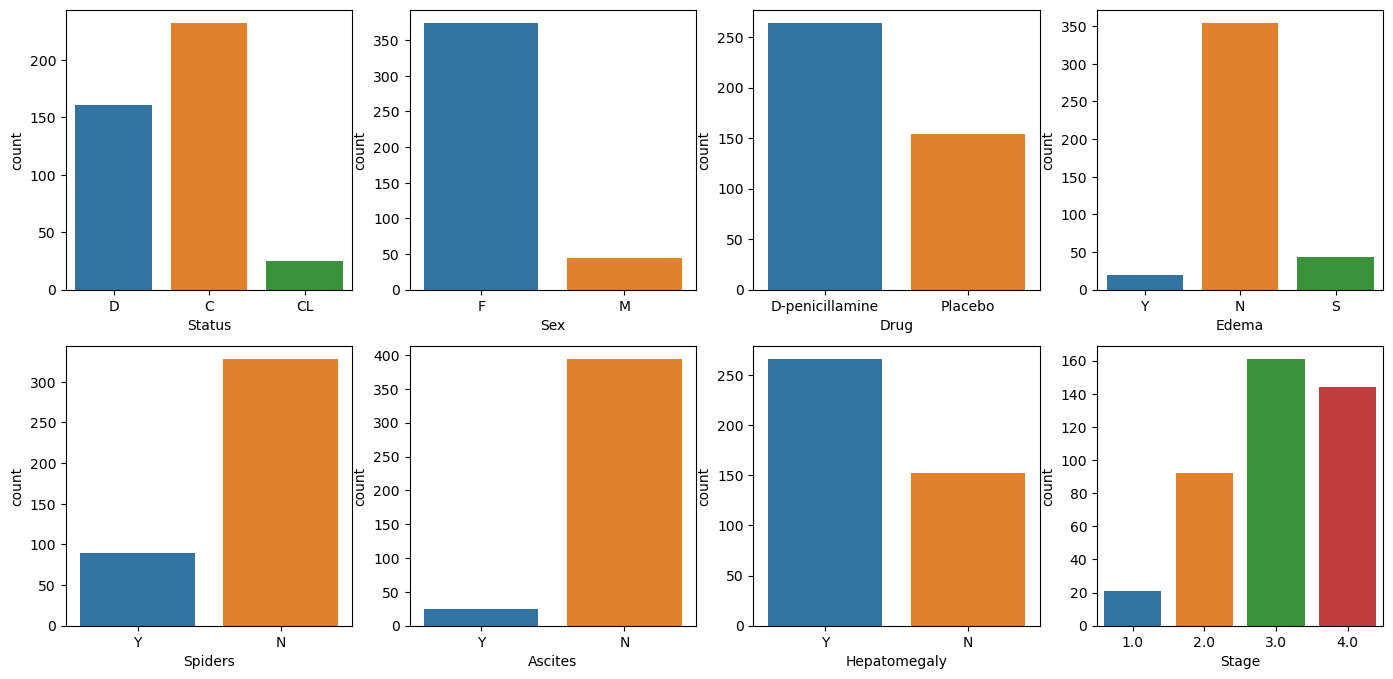

In [17]:
category_df = cir_df.loc[:, cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
fig, ax = plt.subplots(2, 4, figsize = (17,8))
axis = [['Status', 'Sex','Drug','Edema'],['Spiders','Ascites','Hepatomegaly','Stage']]
for i in range(2):
    for j in range(4):
        subplot = sns.countplot(ax = ax[i,j] ,x = axis[i][j], data = category_df)

### Correlation Map

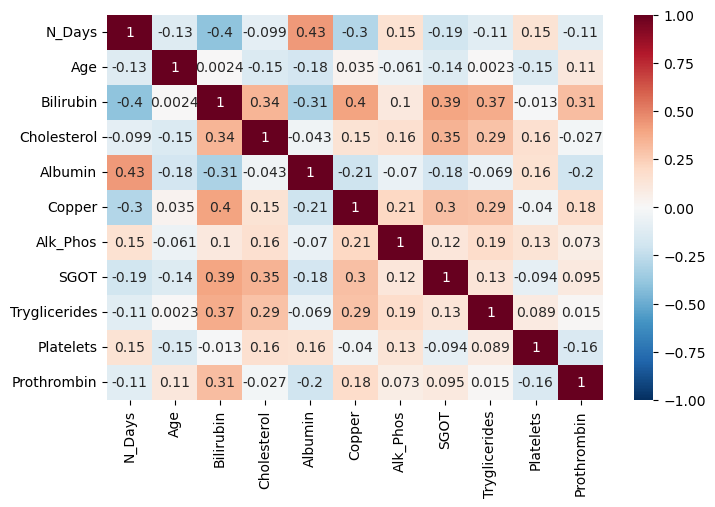

In [18]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(continous_df.corr(), cmap = 'RdBu_r', vmin=-1, vmax=1, annot=True)

### Distribution of variables based on whether have cirrhosis

Since the size of dataset is pretty small, and the distribution of target varible is imbalaced, it would be extra challenging to perform the multiclass classification task (predicting disease stage). Hence the target would be combined to binary form. According to METAVIR metrics, stage1-3 represent different severity of liver firbrosis, and stage4 represents irreversible liver cirrhosis. Target stage would be encoded in binary format, where stage4 = 1 and other stages = 0.

Looking at the distribution of the numerical features, `Bilirubin`, `Age`, `Prothrombin`, `Copper` are suspected to be positively related to the risk of liver cirrhosis.

In [19]:
cir_df["Sex"].replace("M",0,inplace = True)
cir_df["Sex"].replace("F",1,inplace = True)
cir_df["Stage"].replace(4,"x",inplace = True)
cir_df["Stage"].replace(1,0,inplace = True)
cir_df["Stage"].replace(2,0,inplace = True)
cir_df["Stage"].replace(3,0,inplace = True)
cir_df["Stage"].replace("x",1,inplace = True)
cir_df["Hepatomegaly"].replace("Y",1,inplace = True)
cir_df["Hepatomegaly"].replace("N",0,inplace = True)
cir_df["Ascites"].replace("Y",1,inplace = True)
cir_df["Ascites"].replace("N",0,inplace = True)
cir_df["Edema"].replace("Y",1,inplace = True)
cir_df["Edema"].replace("N",0,inplace = True)
cir_df["Edema"].replace("S",0,inplace = True)
cir_df["Status"].replace("CL",0,inplace=True)
cir_df["Status"].replace("C",1,inplace=True)
cir_df["Status"].replace("D",0,inplace=True)
cir_df["Drug"].replace("D-penicillamine",1,inplace = True)
cir_df["Drug"].replace("Placebo",0,inplace = True)
cir_df["Spiders"].replace("Y",1,inplace = True)
cir_df["Spiders"].replace("N",0,inplace = True)

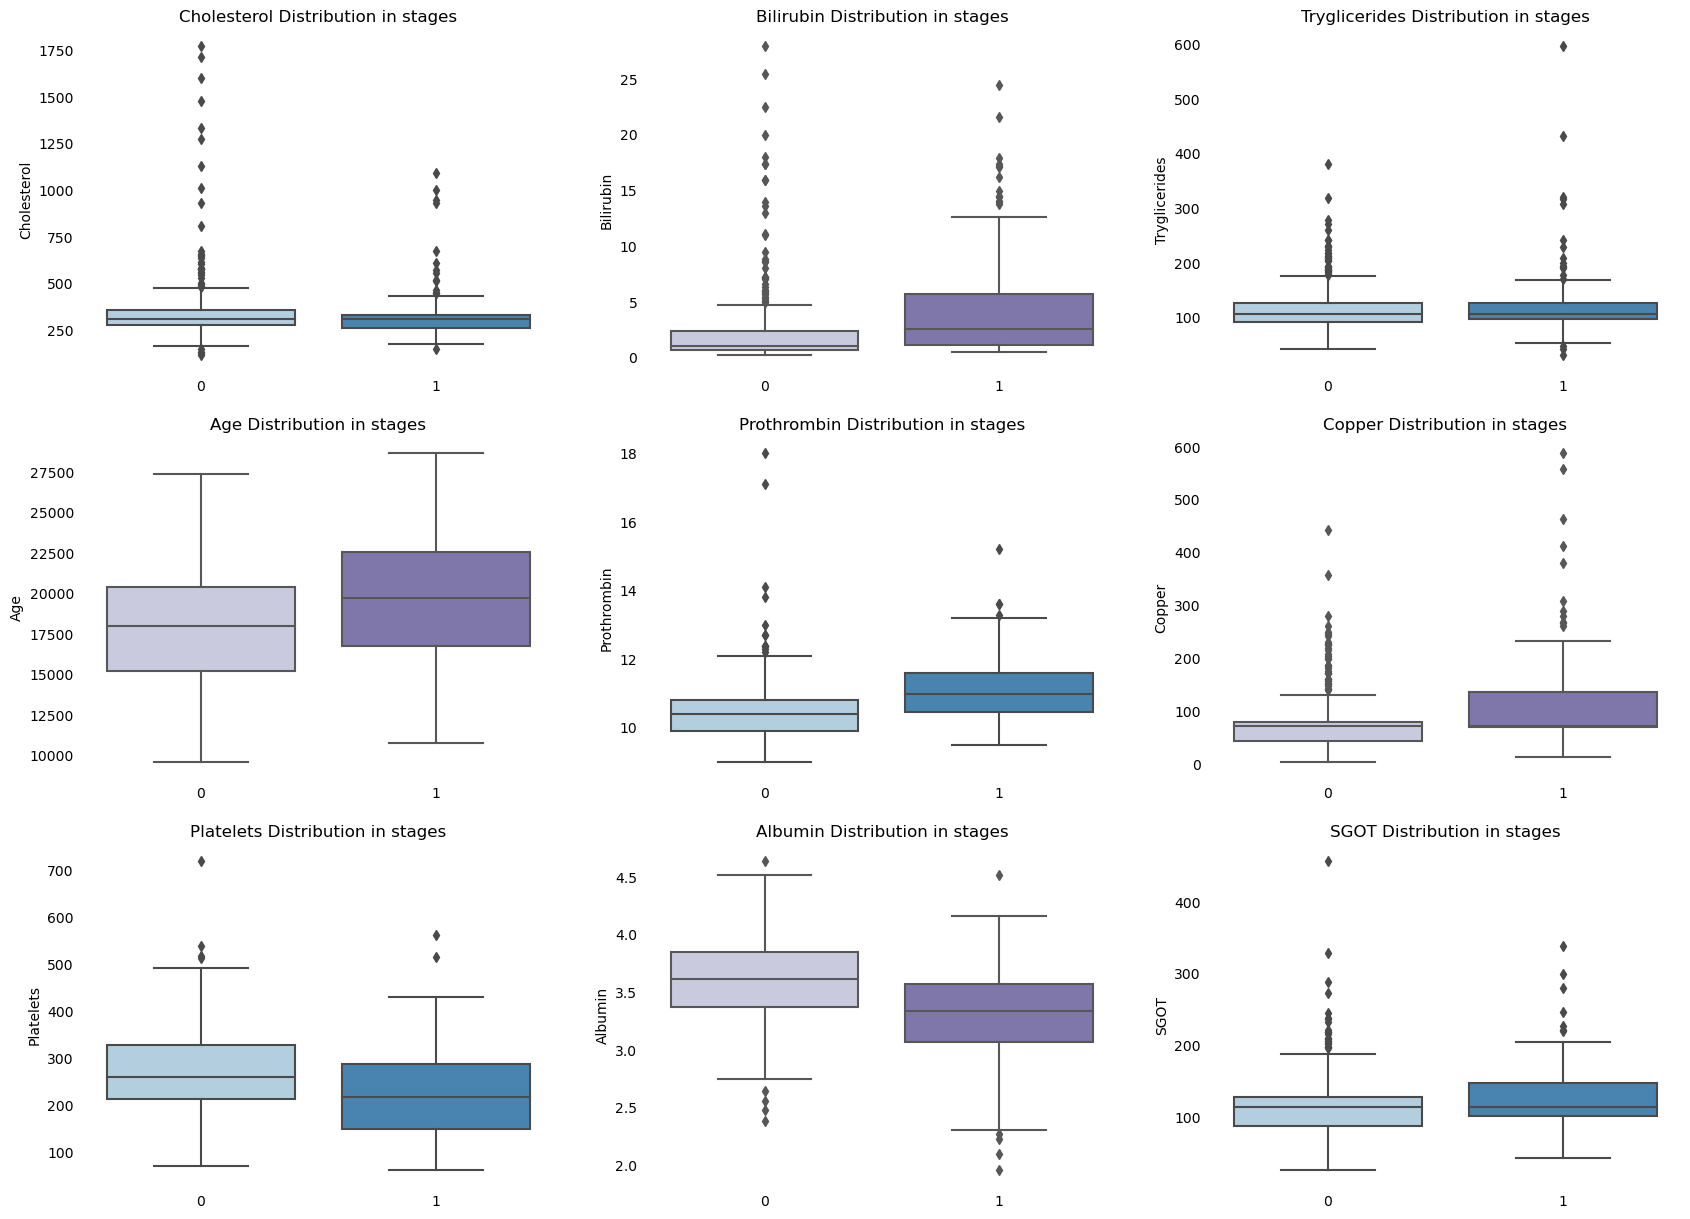

In [20]:
plt.figure(figsize=(20.6,15))
col = ['Cholesterol','Bilirubin','Tryglicerides','Age','Prothrombin','Copper',
       'Platelets','Albumin','SGOT']

for i in range(len(col)):
    var = col[i]
    if i%2 == 0:
        color = 'Blues'
    else:
        color = 'Purples'
    plt.subplot(3,3,i+1)
    sns.boxplot(x='Stage', y=var, data=cir_df, palette=color)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title(var + ' Distribution in stages');

In [21]:
# check the count of the target variable
cir_df['Stage'].value_counts()

0    274
1    144
Name: Stage, dtype: int64

In [22]:
cir_df = cir_df.drop(columns = ['Status','N_Days'])

## Model

Before fitting the model, there is still some manipulations needed to make the dataset eligible to the model.

First, our target `Stage` is seperated from features.

In [23]:
X = cir_df.drop('Stage', axis=1)
y = cir_df["Stage"]

`SMOTE()` is applied to oversample the minor class 1.

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X,y = smote.fit_resample(X,y)

Standard scaling is required to speed up the convergence of MLP and sklearn's logistic model. Most continous columns with relative large range are scaled using `ColumnTransformer()` and `StandardScaler()`.

In [25]:
# using the standard scalar to normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

20% of data is used as test data to validate the performance of the models.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=23)

In [46]:
# ### Applying cross validation of 5 folds with all the models with default parameters
knn = KNeighborsClassifier(n_neighbors=2)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
lgc = LogisticRegression()
svc = SVC()
nbc = GaussianNB()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
sgc = SGDClassifier()
xgb = XGBClassifier()
lda = LinearDiscriminantAnalysis()
mlp = MLPClassifier()
qda = QuadraticDiscriminantAnalysis()
models = [knn,dtc,rfc,lgc,svc,nbc,abc,gbc,sgc,xgb,lda,mlp,qda]
model_names = ["KNearestNeighbor","Decision Tree","Random Forest","Logistic Regression","Support Vector","Naive Bayes","Ada Boost","Gradient Boosting","Stochastic Gradient","XGBoost","LDA","MLP","QDA"]
mean_score = []

for model in models:
    cross_score = cross_val_score(model,X_train,y_train,cv=5)
    average_score = np.mean(cross_score)
    mean_score.append(average_score)

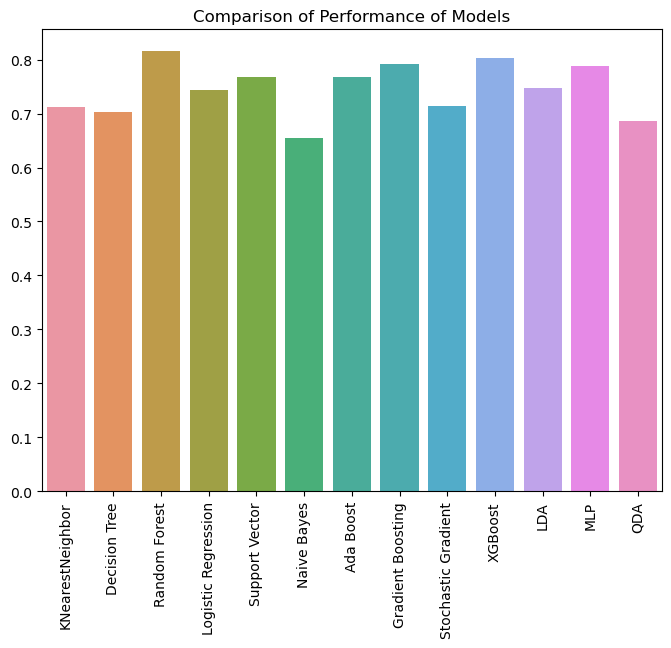

In [86]:
plt.figure(figsize=(8,6))
sns.barplot(x=model_names, y=mean_score)
plt.title("Comparison of Performance of Models")
plt.xticks(rotation=90)
plt.show()

- Here we can see that gradient boosting, XGBoost, support vector classifier and random forest are performing good as compare to the other model. so we will do the hyperparameter tunning of these models in the next step using the grid search CV.

### Random Forest Classifier Hyperparameter Tunning

In [29]:
# applying grid search cv to tune for the best parameters
param = {"n_estimators":[150,200,300,350],"max_depth":[2,4,6,8],"criterion":["gini","entropy","logloss"],"max_features":["sqrt","log2","None"],"class_weight":["balanced","balanced_subsample"]}
grid_search = GridSearchCV(rfc,param_grid=param,cv=5)
# Random Forest GridSearch
grid_search.fit(X_train,y_train)
print("Tuned Random Forest Parameters: {}".format(grid_search.best_params_))

Tuned Random Forest Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 300}


In [63]:
# initiating random forest model with the best parameters
rfc_final = RandomForestClassifier(class_weight ='balanced_subsample',criterion= 'entropy',max_depth= 8,max_features = 'log2', n_estimators = 300)
# fitting it on the training data
rfc_final.fit(X_train,y_train)
# prediction on the test data
rfc_y_pred = rfc_final.predict(X_test)
# computing accuracy score rfc model
rfc_test_score = metrics.accuracy_score(y_test,rfc_y_pred)
print("Accuracy Score of RFC is {}".format(rfc_test_score))

Accuracy Score of RFC is 0.7818181818181819


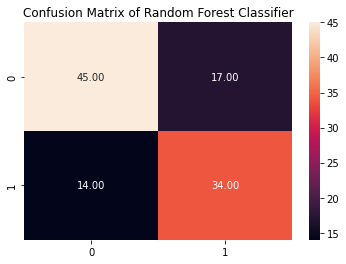

In [31]:
# computing confusion matrix for RFC model and visualizing it using heatmap
rfc_cm = metrics.confusion_matrix(y_test,rfc_y_pred)

sns.heatmap(rfc_cm,annot=True,fmt=".2f")
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

In [43]:
# computing precision score and recall score for Random Forest Classifier
rfc_precision_score = metrics.precision_score(y_test,rfc_y_pred)
print("Precision Score of Random Forest Classifier is {}".format(rfc_precision_score))

print("-" * 70)

rfc_recall_score = metrics.recall_score(y_test,rfc_y_pred)
print("Recall Score of Random Forest Classifier is {}".format(rfc_recall_score))

Precision Score of Random Forest Classifier is 0.6730769230769231
----------------------------------------------------------------------
Recall Score of Random Forest Classifier is 0.7291666666666666


### Support Vector Classifier Hyperparameter Tunning

In [38]:
# applying grid search cv to tune for the best parameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}
# Apply Grid Search CV to tune for the best hyperparameters
grid_search = GridSearchCV(svc, param_grid=param_grid, cv=5)
# Fitting the model with training data
grid_search.fit(X_train, y_train)
# Print the best hyperparameters and the best score
print("Tuned SVC Parameters: {}".format(grid_search.best_params_))

Tuned SVC Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [61]:
# initiating support vector classifier model with the best parameters
svc_final = SVC(C=10, degree = 2, gamma='scale', kernel = 'rbf', probability= True)
# fitting it on the training data
svc_final.fit(X_train,y_train)
# prediction on the test data
svc_y_pred = svc_final.predict(X_test)
# computing accuracy score rfc model
svc_test_score = metrics.accuracy_score(y_test,svc_y_pred)
print("Accuracy Score of RFC is {}".format(svc_test_score))

Accuracy Score of RFC is 0.7545454545454545


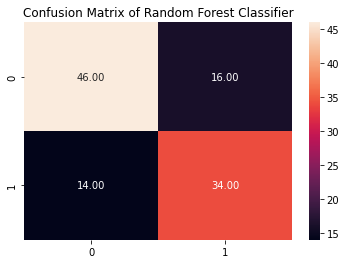

In [41]:
# computing confusion matrix for RFC model and visualizing it using heatmap
svc_cm = metrics.confusion_matrix(y_test,svc_y_pred)
sns.heatmap(svc_cm,annot=True,fmt=".2f")
plt.title("Confusion Matrix of Support Vector Classifier")
plt.show()

In [44]:
# computing precision score and recall score for SVM Classifier
svc_precision_score = metrics.precision_score(y_test,svc_y_pred)
print("Precision Score of Support Vector Classifier is {}".format(svc_precision_score))

print("-" * 70)

rfc_recall_score = metrics.recall_score(y_test,rfc_y_pred)
print("Recall Score of Support Vector Classifier is {}".format(rfc_recall_score))

Precision Score of Support Vector Classifier is 0.68
----------------------------------------------------------------------
Recall Score of Support Vector Classifier is 0.7291666666666666


### XGBoost Classifier Hyperparameter Tunning

In [28]:
# Define the hyperparameters to be tuned
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 4, 6]
}

# Create the XGBoost Classifier object
xgb = XGBClassifier()

# Apply Grid Search CV to tune for the best hyperparameters
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Tuned XGBoost Parameters: {}".format(grid_search.best_params_))

Tuned XGBoost Parameters: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 200}


In [76]:
# initiating Gradient Boosting classifier model with the best parameters
xgb_final = XGBClassifier(learning_rate = 0.5, max_depth = 2, n_estimators = 200)
# fitting it on the training data
start = time.time()
# prints: Training time: 0.20307230949401855s
xgb_final.fit(X_train,y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
# prediction on the test data
xgb_y_pred = xgb_final.predict(X_test)
# computing accuracy score rfc model
xgb_test_score = metrics.accuracy_score(y_test,xgb_y_pred)
print("Accuracy Score of XGBoost classifier is {}".format(xgb_test_score))

Training time: 0.07708907127380371s
Accuracy Score of XGBoost classifier is 0.7818181818181819


### Gradient Boosting Classifier Hyperparameter Tunning

In [29]:
# Define the hyperparameters to be tuned
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create the Gradient Boosting Classifier object
gbc = GradientBoostingClassifier()

# Apply Grid Search CV to tune for the best hyperparameters
grid_search = GridSearchCV(gbc, param_grid=param_grid, cv=5)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Tuned Gradient Boosting Parameters: {}".format(grid_search.best_params_))

Tuned Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}


In [78]:
# initiating Gradient Boosting classifier model with the best parameters
gbc_final = GradientBoostingClassifier(learning_rate = 0.5, max_depth = 6, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4, n_estimators = 300)
# fitting it on the training data
start = time.time()
# prints: Training time: 0.20307230949401855s
gbc_final.fit(X_train,y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
# prediction on the test data
gbc_y_pred = gbc_final.predict(X_test)
# computing accuracy score rfc model
gbc_test_score = metrics.accuracy_score(y_test,gbc_y_pred)
print("Accuracy Score of Gradient Boosting classifier is {}".format(gbc_test_score))

Training time: 0.1797797679901123s
Accuracy Score of Gradient Boosting classifier is 0.8


In [51]:
start = time.time()
# prints: Training time: 0.13385701179504395s
gbc.fit(X_train,y_train)
stop = time.time()
print(f"Default gbc model Training time: {stop - start}s")
print(f"Default gbc model Test set accuracy: {metrics.accuracy_score(y_test,gbc.fit(X_train,y_train).predict(X_test))}")

Default gbc model Training time: 0.12961816787719727s
Default gbc model Test set accuracy: 0.7454545454545455


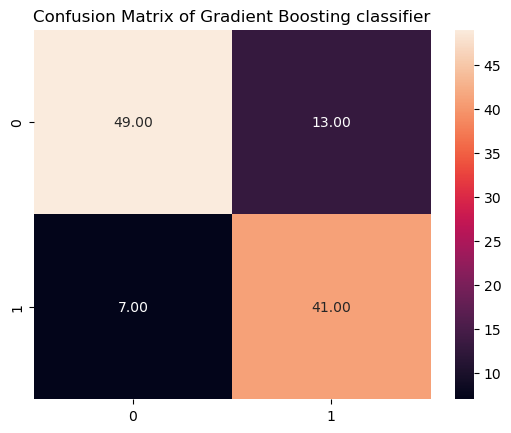

In [72]:
# computing confusion matrix for RFC model and visualizing it using heatmap
gbc_cm = metrics.confusion_matrix(y_test,gbc_y_pred)
sns.heatmap(gbc_cm,annot=True,fmt=".2f")
plt.title("Confusion Matrix of Gradient Boosting classifier")
plt.show()

In [59]:
# computing precision score and recall score for Random Forest Classifier
gbc_precision_score = metrics.precision_score(y_test,gbc_y_pred)
print("Precision Score of Gradient Boosting classifier is {}".format(gbc_precision_score))

print("-" * 70)

gbc_recall_score = metrics.recall_score(y_test,gbc_y_pred)
print("Recall Score of Gradient Boosting classifier is {}".format(gbc_recall_score))

Precision Score of Gradient Boosting classifier is 0.7592592592592593
----------------------------------------------------------------------
Recall Score of Gradient Boosting classifier is 0.8541666666666666


### Comparison of final models

In [73]:
# function to draw ROC curve
def roc_plot(classifier_list,name_list,xtest,ytest):
    for i in range(len(classifier_list)):
        classifier = classifier_list[i]
        name = name_list[i]
        y_proba = classifier.predict_proba(xtest)
        fpr, tpr, thresholds = roc_curve(ytest, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label= name + ' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random Classifier')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve and AUC')
    plt.legend(loc="lower right")
    plt.show()
    return

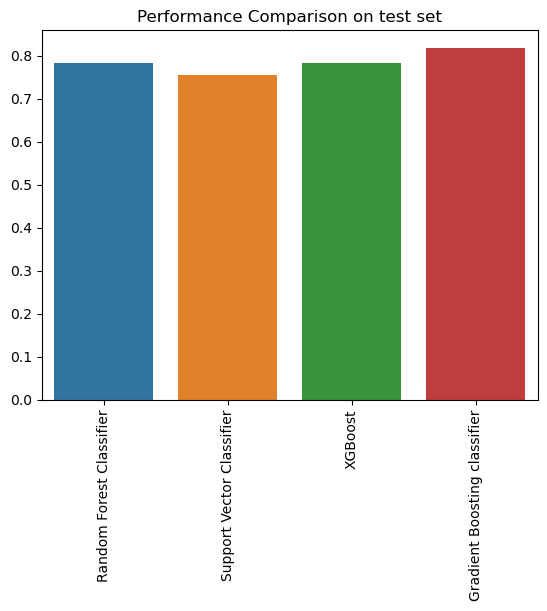

In [72]:
# plotting a bar graph to compare performance of Random Forest and Logistic Regression model
sns.barplot(x=["Random Forest Classifier","Support Vector Classifier", "XGBoost", "Gradient Boosting classifier"],y = [rfc_test_score,svc_test_score, xgb_test_score,gbc_test_score])
plt.title("Performance Comparison on test set")
plt.xticks(rotation=90)
plt.show()

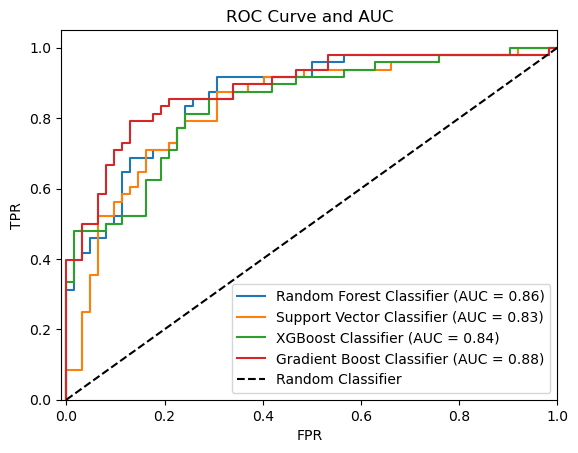

In [64]:
roc_plot([rfc_final,svc_final,xgb_final,gbc_final],['Random Forest Classifier','Support Vector Classifier','XGBoost Classifier','Gradient Boost Classifier'],X_test,y_test)

### Final Model Evaluation

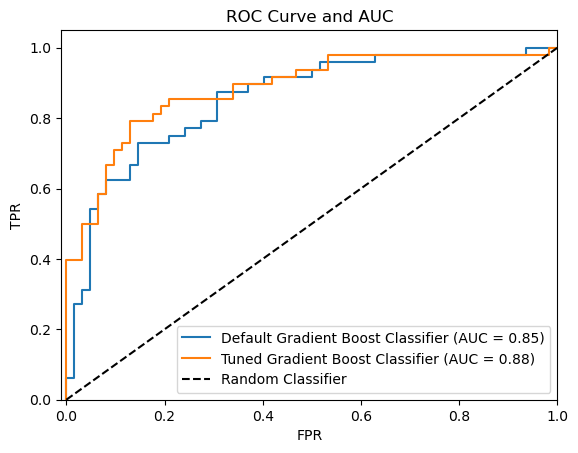

In [74]:
roc_plot([gbc,gbc_final],['Default Gradient Boost Classifier','Tuned Gradient Boost Classifier'],X_test,y_test)

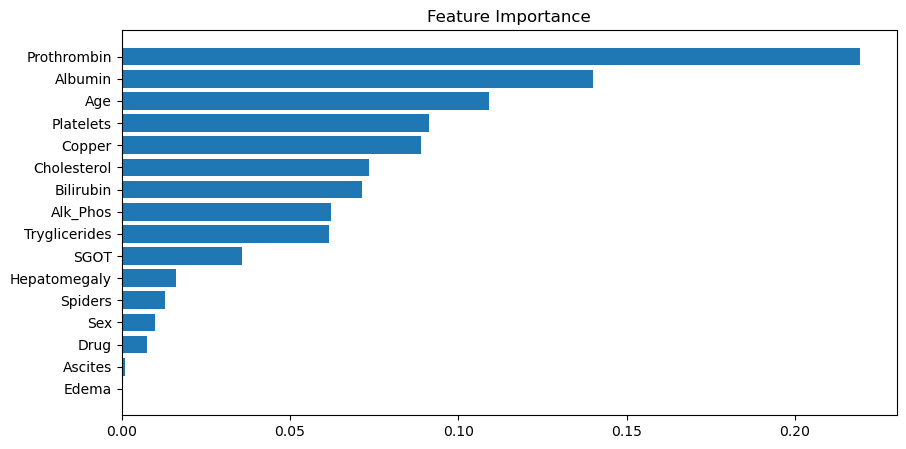

In [71]:
feature_importance = gbc_final.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()